In [1]:
# load data
import numpy as np
import pandas as pd
# df = pd.read_excel('OuterHarbour-Tiel.xlsx')
# df = pd.read_excel('OuterHarbour-Tiel2.xlsx')
# df = pd.read_excel('OuterHarbour-Tiel3.xlsx')
all_files = ['AU-NL.xlsx', ]
df = pd.concat((pd.read_excel(f) for f in all_files))

In [2]:
# All nodes on the route
locs = df[["locationType", "cityName", "countryName"]].to_numpy().astype('str')
nodes = np.unique(locs, axis=0)
node_cols = [f'{node[0]}_{node[1]}_{node[2]}_visited' for node in nodes] + [f'{node[0]}_{node[1]}_{node[2]}_planned' for node in nodes]
node_df = pd.DataFrame(np.zeros((df.shape[0], len(node_cols)), dtype=np.bool8), columns=node_cols)
node_df.head()
df = pd.concat([df, node_df], axis=1)

In [3]:
df = df[df["ordSeaFreightMainTransportInvolvement"] == "J"]
df["ordJFHArrangeLoadingPickup"].fillna("", inplace=True)
df["ordJFHArrangeDelivery"].fillna("", inplace=True)
df["ordReqDeliveryDate"].fillna("", inplace=True)

In [4]:
from math import sqrt, pow

def node_name(node):
    # node = node.iloc[0]
    return f'{node["locationType"]}_{node["cityName"]}_{node["countryName"]}'

def abs_distance(o, lat, long):
    # o = origin_node.iloc[0]
    diff_lat = abs(o["latitude"] - lat) * 111.139
    diff_long =  abs(o["longitude"] - long) * 111.139
    res = sqrt(pow(diff_lat, 2) + pow(diff_long, 2))
    return res if res != 0 else 1

def dep_late(port, node_created):
    if node_created > port["actualDepDate"]:
        return "yes" if port["actualDepDate"] > port["estimatedDepDate"] else "no"
    return "unknown"
    

def get_created_date(rowNo, destination, ordCreate, reqPortL, reqPortD, origDest, locType, readyDate, actArrDate):
    if rowNo == 1:
        return ordCreate
    elif rowNo == destination["rowNo"]:
        return ordCreate
    elif origDest == "O" and locType.strip() == "P":
        return ordCreate if reqPortL else readyDate
    elif origDest == "D" and locType.strip() == "P":
        return ordCreate if reqPortD else readyDate
    return actArrDate

def get_port(port, node_created):
    return node_name(port) if node_created >= port["created"] else "unknown"

df["origin"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == 1)].iloc[0] for shipmentID in df["shipmentID"]]
df["originCountry"] = [o["countryName"] for o in df["origin"]]
df["destination"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == df[df["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0] for shipmentID in df["shipmentID"]]
df["destinationCountry"] = [d["countryName"] for d in df["destination"]]
df["created"] = [get_created_date(*values) for values in df[["rowNo", "destination", "ordaCreateDate", "prtReqPOL", "prtReqPOD", "originDestination", "locationType", "readyDate", "actualArrDate"]].values]
df["created"] = df["created"].astype(object)
df["readyDate"] = [o["readyDate"] for o in df["origin"]]
df["consolidation"] = (df["ordtType"].str.strip() == "LF") | (df["ordtType"].str.strip() == "LFL")
df["deconsolidation"] = df["ordtType"].str.strip() == "LFL"
df["serviceType"] = [f"{'door' if p == 'Y' else 'port'}-to-{'door' if d == 'Y' else 'port'}" for p, d in df[["ordJFHArrangeLoadingPickup", "ordJFHArrangeDelivery"]].values]
df["pastTimeToOrigin"] = [arr_date - orig["actualDepDate"] for orig, arr_date in df[["origin", "actualArrDate"]].values]
df["pastTimeToOrigin"] = df["pastTimeToOrigin"] / pd.Timedelta(hours=1)
df["pastAvgAbsSpeed"] = [past_time / abs_distance(orig, lat, long) for (lat, long, orig, past_time) in df[["latitude", "longitude", "origin", "pastTimeToOrigin"]].values]
df["counterStops"] = df["rowNo"] - 1
df["departureOrigin"] = [o["actualDepDate"] if (i > 1 and o["actualDepDate"] > created) else None for (o, created, i) in df[["origin", "created", "rowNo"]].values]
df["numberOfTEU"] = df["ordExpectedNBOfContainers"]
df["totalWeight"] = df["ordGrossWeightKGM"]
df["ETA"] = df["ordReqDeliveryDate"]
df["ATA"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == df[df["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0]["actualArrDate"] for shipmentID in df["shipmentID"]]
df = df[df["ATA"].notna()]
df["currentMonth"] = [c.month for c in df["created"].values]
df["portOfLoading"] = [get_port(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["portOfDischarge"] = [get_port(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "D")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["portDestCongestion"] = 0 # external source needed
df["portOfLoadingLate"] = [dep_late(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["origin"] = [node_name(o) for o in df["origin"]]
df["destination"] = [node_name(d) for d in df["destination"]]
# set visited path and future path
ss = np.unique(df["shipmentID"])
paths = [df[df["shipmentID"] == s][["locationType", "cityName", "countryName"]].apply(lambda x : node_name(x), axis=1) for s in ss]
for path, shipment in zip(paths, ss):
    for i in range(1, len(path) + 1):
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_visited" for n in path[:i]]] = True
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_planned" for n in path[i-1:]]] = True

    # set ETA and ATA for all shipment records and convert to time delta 
    shipment_dep_row = df.loc[(df["shipmentID"] == shipment) & (df["actualDepDate"].notnull())].iloc[0]
    shipment_arr = shipment_dep_row['ATA']
    shipment_est_arr = shipment_dep_row['ETA']
    shipment_dep = shipment_dep_row['actualDepDate']
    df.loc[df["shipmentID"] == shipment, ["ATA",]] = shipment_arr - shipment_dep
    if shipment_est_arr:
        df.loc[df["shipmentID"] == shipment, ["ETA",]] = shipment_est_arr - shipment_dep


# convert datetime to number of days 
df["departureOrigin"] = pd.to_datetime(df["departureOrigin"])
df["departureMonthOrigin"] = df["departureOrigin"].apply(lambda x : x.month)
df["departureDayOrigin"] = df["departureOrigin"].apply(lambda x : x.isoweekday())

In [5]:
df = df.drop(columns=["departureOrigin", "estimatedDepDate", "created", "readyDate", "estimatedArrDate", "actualDepDate", "prtReqPOL", "prtReqPOD", "ordReqShipDate", "ordaCreateDate", "ordReqDeliveryDate", "latitude" , "longitude", "actualArrDate", "ordExpectedNBOfContainers", "ordGrossWeightKGM", "rowNo", "shipmentID", "originDestination", "locationType", "cityName", "countryName", "ordtType", "ordJFHArrangeLoadingPickup", "ordSeaFreightMainTransportInvolvement", "ordJFHArrangeDelivery"])

In [6]:
df.replace([np.inf, -np.inf], 0, inplace=True)
df["departureMonthOrigin"].fillna(0, inplace=True)
df["departureDayOrigin"].fillna(0, inplace=True)
df["numberOfTEU"].fillna(0, inplace=True)

df = df.astype({
    "origin" : 'category',
    "originCountry" : 'category',
    "destination" : 'category',
    "destinationCountry" : 'category',
    "serviceType" : 'category',
    "portOfLoading" : 'category',
    "portOfLoadingLate" : 'category',
    "portOfDischarge" : 'category',
    "departureMonthOrigin" : 'int64',
    "departureDayOrigin" : 'int64',
    "consolidation" : "int",
    "deconsolidation" : "int"
})
df["ATA"] = df["ATA"] / pd.Timedelta(hours=1)
df["ETA"] = df["ETA"] / pd.Timedelta(hours=1)
for node in nodes:
    df[f'{node[0]}_{node[1]}_{node[2]}_visited'] = df[f'{node[0]}_{node[1]}_{node[2]}_visited'].astype(int)
    df[f'{node[0]}_{node[1]}_{node[2]}_planned'] = df[f'{node[0]}_{node[1]}_{node[2]}_planned'].astype(int)
df["origin"] = df["origin"].factorize()[0]
df["originCountry"] = df["originCountry"].factorize()[0]
df["destination"] = df["destination"].factorize()[0]
df["destinationCountry"] = df["destinationCountry"].factorize()[0]
df["portOfLoading"] = df["portOfLoading"].factorize()[0]
df["portOfLoadingLate"] = df["portOfLoadingLate"].factorize()[0]
df["portOfDischarge"] = df["portOfDischarge"].factorize()[0]
df["serviceType"] = df["serviceType"].factorize()[0]

In [7]:
# drop all the columns in the dataset that have only a single value
def constant_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

cols_single_value = constant_cols(df)
cols_to_drop = [column for (i, column) in enumerate(df.columns) if cols_single_value[i]]
print(f'Dropping columns {cols_to_drop} because they contain only a single value')
df = df.drop(columns=cols_to_drop)

Dropping columns ['A _Adelaide_Australia_visited', 'A _Amsterdam_Netherlands_visited', 'A _Bannockburn_Australia_visited', 'A _Basket Range_Australia_visited', 'A _Bilbul_Australia_visited', 'A _Cheltenham/Melbourne_Australia_visited', 'A _Cottesloe_Australia_visited', 'A _Gillman_Australia_visited', 'A _Langhorne Creek_Australia_visited', 'A _Lyndoch_Australia_visited', 'A _Oakbank_Australia_visited', 'A _Outer Harbor_Australia_visited', 'A _Rhoon_Netherlands_visited', 'A _Richmond_Australia_visited', 'A _Rowland Flat_Australia_visited', 'A _Sassenheim_Netherlands_visited', 'A _Schiedam_Netherlands_visited', 'A _Seppeltsfield_Australia_visited', 'A _Sevenhill_Australia_visited', 'A _Stockwell_Australia_visited', 'A _Tatachilla_Australia_visited', 'A _Trentham Cliffs_Australia_visited', 'A _Venlo_Netherlands_visited', 'A _Vijfhuizen_Netherlands_visited', 'A _Waddinxveen_Netherlands_visited', 'A _Woodcroft_Australia_visited', 'A _Zuidoostbeemster_Netherlands_visited', 'D _Port Melbourne

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

y = df["ATA"]
X = df.drop(columns=["ATA"])

feature_names = X.columns

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

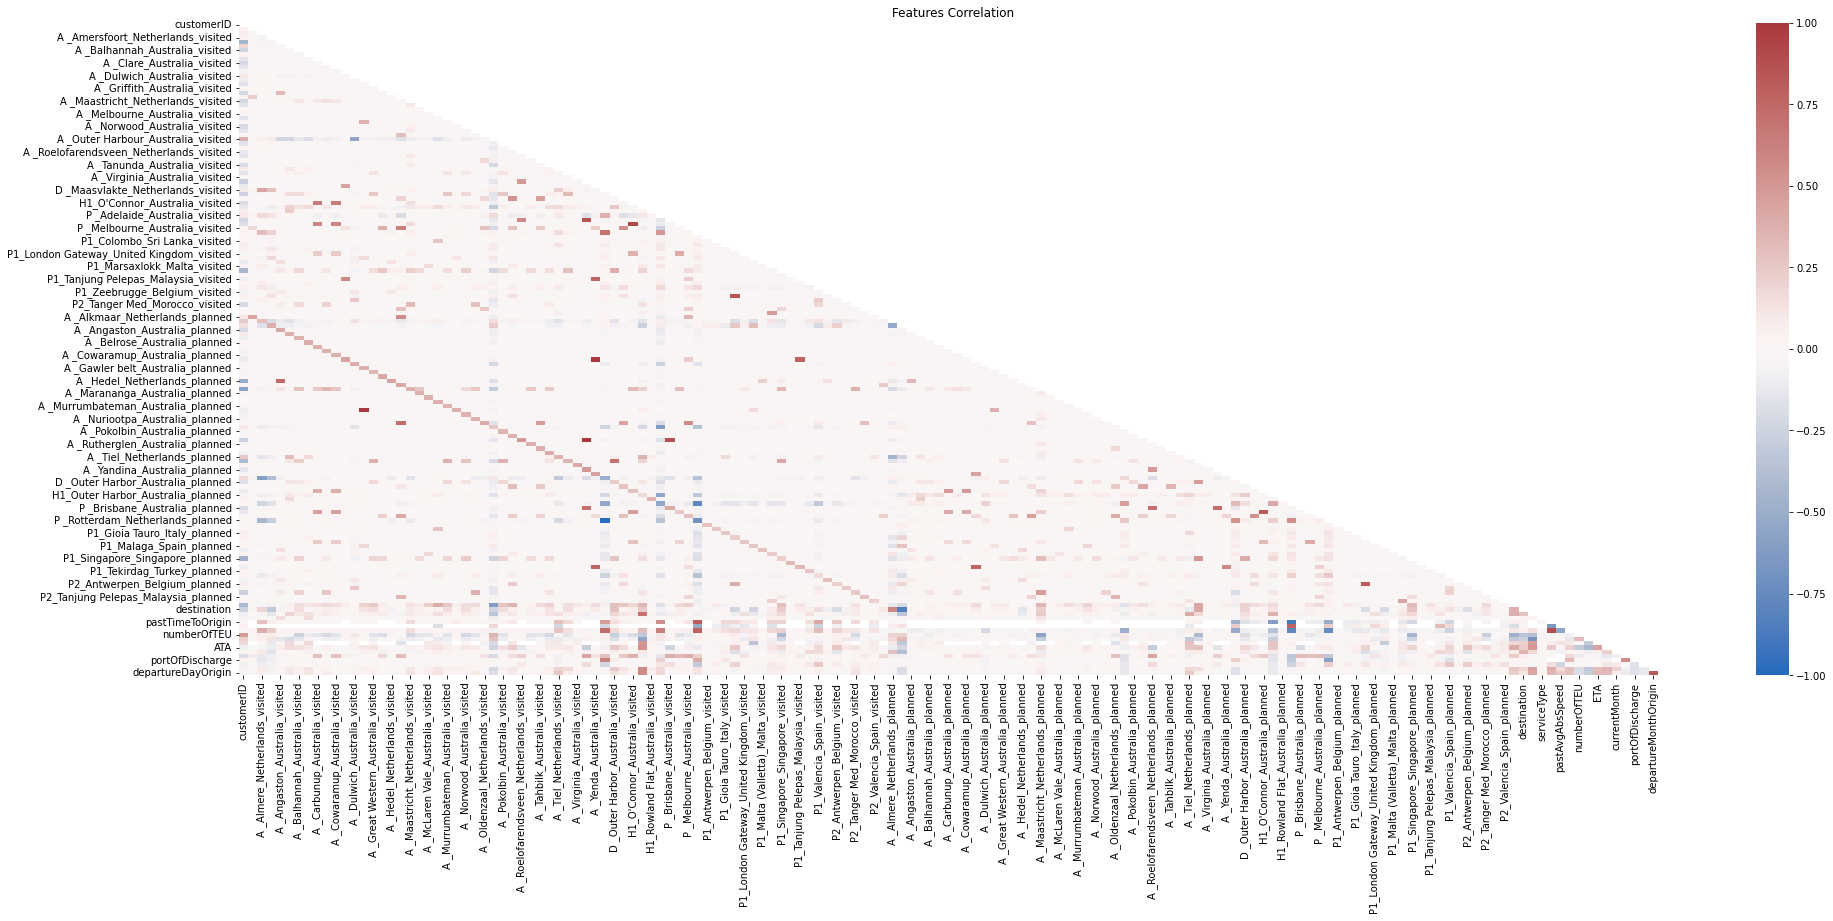

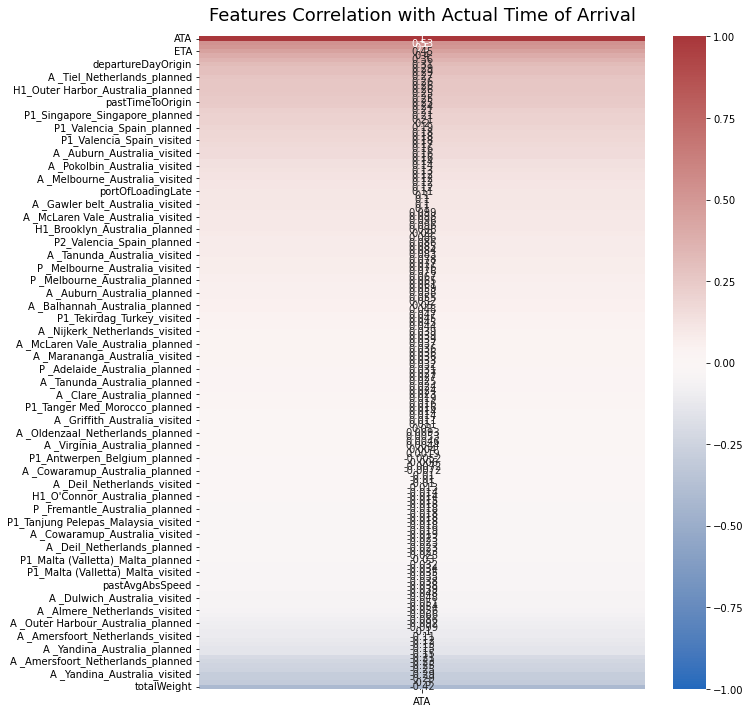

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(32, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool8))
heatmap = sns.heatmap(corr_matrix, vmin=-1, mask=mask, vmax=1, cmap='vlag')
heatmap.set_title('Features Correlation')

plt.savefig('output/correlation.png')

plt.figure(figsize=(10, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(corr_matrix[['ATA']].sort_values(by='ATA', ascending=False), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Features Correlation with Actual Time of Arrival', fontdict={'fontsize':18}, pad=16)

plt.savefig('output/correlation_ata.png')

In [10]:
from typing import List, Set

def avg(x):
    return sum(x) / len(x)

corr_matrix = df.corr()
f_c_matrix = corr_matrix[["ATA"]].abs().drop('ATA')
f_f_matrix = corr_matrix.abs().drop('ATA')

def merit_S(S:Set):
    k = len(S)
    avg_f_c_corr = avg([f_c_matrix.loc[s]["ATA"] for s in S])
    scores = []
    for i in S:
        for j in S:
            scores.append(f_f_matrix[i][j])
    avg_f_f_corr = avg(scores)
    return (k * avg_f_c_corr) / sqrt((k + k * (k - 1)) * avg_f_f_corr)

def best_first_search() -> Set[str]:
    def create_single_expansion(subset) -> List[Set]:
        return [subset.union({f}) for f in X_train]

    max_no_improvement = 5
    def search(subset:Set, prev_score, count_no_improvement, current_best_subset = None, current_best_score = None) -> Set[str]:
        if count_no_improvement > max_no_improvement:
            return current_best_subset
        subsets = create_single_expansion(subset)
        subsets_with_merits = [(S, merit_S(S)) for S in subsets]
        new_subset, max_score = max(subsets_with_merits, key=lambda x: x[1])

        if not current_best_score or max_score > current_best_score:
            current_best_score = max_score
            current_best_subset = new_subset

        if max_score <= prev_score:
            new_subset, max_score = max([(S, merit) for S, merit in subsets_with_merits if S != new_subset], key=lambda x: x[1])
            count_no_improvement += 1
        else:
            count_no_improvement = 0

        return search(new_subset, max_score, count_no_improvement, current_best_subset=current_best_subset)
    
    return search(set(), 0, 0)
    

cfs_result = list(best_first_search())
print(f"CFS selected the following {len(cfs_result)} features: {cfs_result}")

CFS selected the following 26 features: ['D _Outer Harbor_Australia_visited', 'A _McLaren Vale_Australia_visited', 'consolidation', 'P1_Le Havre_France_visited', 'P _Brisbane_Australia_visited', 'A _Yandina_Australia_planned', 'A _Yandina_Australia_visited', 'P2_Antwerpen_Belgium_planned', 'A _Tilburg_Netherlands_planned', 'D _Outer Harbor_Australia_planned', 'departureMonthOrigin', 'P1_Valencia_Spain_planned', 'A _Relbia_Australia_visited', 'H1_Outer Harbor_Australia_planned', 'P2_Antwerpen_Belgium_visited', 'P2_Tanger Med_Morocco_planned', 'A _Roelofarendsveen_Netherlands_planned', 'H1_Outer Harbor_Australia_visited', 'departureDayOrigin', 'P2_Valencia_Spain_planned', 'totalWeight', 'P1_Le Havre_France_planned', 'P1_Valencia_Spain_visited', 'A _Nijkerk_Netherlands_planned', 'origin', 'A _Tiel_Netherlands_planned']


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = X[X.columns.intersection(cfs_result)]

feature_names = X.columns

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [53]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error

# import wandb
# # from wandb.sklearn import plot_learning_curve

# wandb.init(project="thesis-code")
# regr = svm.SVR(kernel='linear')
# regr.fit(X_train.values, y_train.values)
# wandb.sklearn.plot_regressor(regr, X_train.values, X_test.values, y_train.values, y_test.values,  model_name='SVR')

from sklearn.dummy import DummyRegressor

pipe_dummy = make_pipeline(StandardScaler(), DummyRegressor(strategy='mean'))
pipe_dummy.fit(X_train, y_train)
print(pipe_dummy.score(X_test, y_test))

pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='linear'))])
pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))

-0.002167503756391964
0.707933510152088


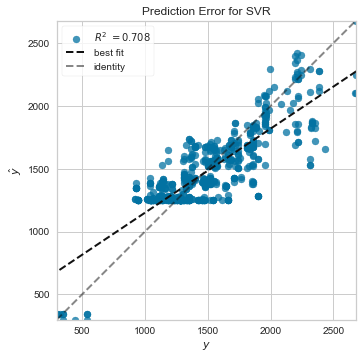

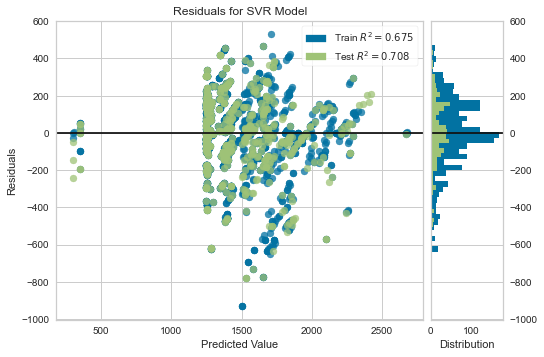

<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [54]:
from yellowbrick.regressor import ResidualsPlot, PredictionError

visualizer = PredictionError(pipe['svr'])
visualizer.fit(pipe['scaler'].transform(X_train), y_train)
visualizer.score(pipe['scaler'].transform(X_test), y_test)
visualizer.show()

visualizer = ResidualsPlot(pipe['svr'])
visualizer.fit(pipe['scaler'].transform(X_train), y_train)
visualizer.score(pipe['scaler'].transform(X_test), y_test)
visualizer.show()

In [ ]:
# from sklearn import svm
# from sklearn.feature_selection import RFE
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split


# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import RepeatedStratifiedKFold, KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.feature_selection import RFECV 
# from sklearn.ensemble import GradientBoostingClassifier

# # regr = svm.SVR(kernel='linear')
# # rfecv = RFECV(regr, step=5)
# # pipeline = Pipeline([('Feature Selection', rfecv), ('Model', regr)])
# # cv = KFold(n_splits=2, shuffle=True, random_state=41835139)
# # n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# # np.mean(n_scores)
# # res = pipeline.fit(X_train,y_train)

# regr = svm.SVR(kernel='linear')
# selector = RFECV(regr, step=5)
# selector = selector.fit(X_train, y_train)
# n_features = len(selector.cv_results_['mean_test_score'])
# print("Optimal number of features : %d" % n_features)
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (accuracy)")
# plt.plot(range(n_features), selector.cv_results_['mean_test_score'],)
# plt.plot(range(n_features), selector.cv_results_['std_test_score'],)
# plt.savefig('output/rfe.png')

# supported_features = [(feature, rank) for feature, support, rank in zip(X.columns, selector.support_, selector.ranking_) if support]
# all_features = [(feature, support, rank) for feature, support, rank in zip(X.columns, selector.support_, selector.ranking_)]

# with open('output/feature_ranking.txt', 'w+') as f:
#     for feature, support, rank in all_features:
#         f.write(f"{feature}, {support}, {rank}\n")

In [ ]:
# from sklearn import svm
# from sklearn.feature_selection import RFE
# from sklearn.inspection import permutation_importance
# import matplotlib.pyplot as plt

# regr = svm.SVR(kernel='rbf')
# regr.fit(X, y)
# perm_importance = permutation_importance(regr, X, y)

# features = np.array(feature_names)

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.figure(figsize=(6, 12))
# plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])

# plt.xlabel("Permutation Importance")

In [ ]:
df.to_excel("output/output.xlsx")